In [30]:
import sys
import os.path
import pylab as plt
from zedstat.zedstat import zedstat
import pandas as pd

In [31]:
#
# order is order of spline used for smoothing
# alpha is significance level
# prevalence is prevalence of positive class
# 
zt=zedstat(df=pd.read_csv('examples_data/roc2.csv'),
           order=3, 
           total_samples=100000,
           positive_samples=1000,
           alpha=0.1,
           prevalence=.01)

In [32]:
# compute smoothened roc and other performance measures
zt.smooth(STEP=0.001)
zt.allmeasures(interpolate=True)
zt.usample(precision=3)
zt.getBounds()

In [33]:
zt.df_lim['U']

,tpr,ppv,acc,npv,LR+,LR-,threshold
fpr,,,,,,,
0.000000,0.000000,0.192491,0.990000,0.990000,92.440474,1.000000,1.470513
0.000836,0.094300,0.532697,0.990116,0.990927,112.853788,0.906457,0.380974
0.001768,0.157680,0.473977,0.989827,0.991549,89.204773,0.843812,0.349475
0.002716,0.195601,0.421156,0.989268,0.991918,72.030588,0.806589,0.332624
0.003672,0.233211,0.390830,0.988697,0.992286,63.516129,0.769614,0.315774
...,...,...,...,...,...,...,...
0.995672,1.000000,0.010043,0.014285,1.000000,1.004347,0.000000,0.001358
0.996716,1.000000,0.010033,0.013252,1.000000,1.003295,0.000000,0.001356
0.997768,1.000000,0.010022,0.012210,1.000000,1.002237,0.000000,0.001355


In [34]:
zt.df_lim['L']

,tpr,ppv,acc,npv,LR+,LR-,threshold
fpr,,,,,,,
0.000000,0.000000,0.163390,0.990000,0.990000,44.377143,1.000000,1.470513
0.001164,0.066050,0.364260,0.989508,0.990644,56.723981,0.935039,0.380974
0.002232,0.121621,0.354965,0.989006,0.991186,54.480113,0.880345,0.349475
0.003284,0.156002,0.324218,0.988308,0.991519,47.496935,0.846779,0.332624
0.004328,0.190695,0.307971,0.987622,0.991857,44.057660,0.812823,0.315774
...,...,...,...,...,...,...,...
0.996328,1.000000,0.010036,0.013635,1.000000,1.003685,0.000000,0.001358
0.997284,1.000000,0.010027,0.012688,1.000000,1.002723,0.000000,0.001356
0.998232,1.000000,0.010018,0.011750,1.000000,1.001771,0.000000,0.001355


Text(0, 0.5, 'tpr')

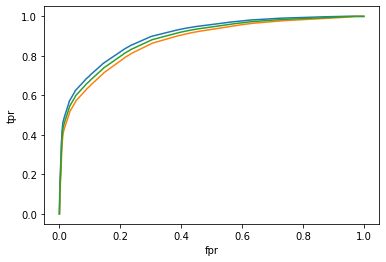

In [4]:
ax=zt.df_lim['U'].tpr.plot()
ax=zt.df_lim['L'].tpr.plot(ax=ax)
ax=zt.get().tpr.plot(ax=ax)
ax.set_ylabel('tpr')

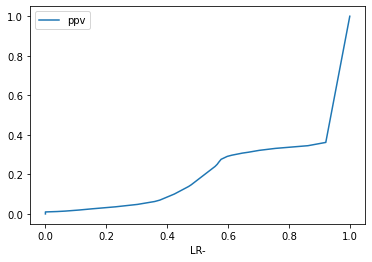

In [5]:
ax=zt.get().plot(x='LR-',y='ppv')

In [6]:
# compute auc with confidence bounds
zt.auc(alpha=.001)

(0.8875903790087464, 0.914707250237766, 0.8600825842465808)

In [7]:
# required sample size
zt.samplesize(delta_auc=.1)

26.99420757849582

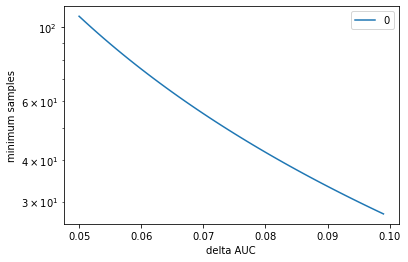

In [8]:
import numpy as np
pd.DataFrame(np.array([zt.samplesize(delta_auc=a) 
                       for a in np.arange(.05,.1,.001)]),
             np.arange(.05,.1,.001)).plot(logy=True)
plt.gca().set_xlabel('delta AUC')
plt.gca().set_ylabel('minimum samples');

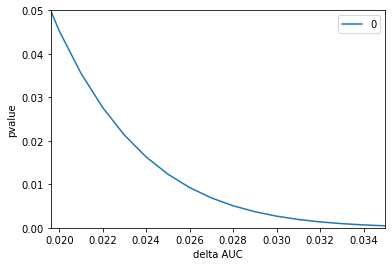

In [9]:
pd.DataFrame([zt.pvalue(delta_auc=a) for a in np.arange(0.001,.1,.001)],
             np.arange(0.001,.1,.001)).plot()
plt.gca().set_ylim(0,0.05)   
plt.gca().set_xlim(0.0196,0.035)   
plt.gca().set_xlabel('delta AUC')
plt.gca().set_ylabel('pvalue');

In [10]:
zt.operating_zone(LRminus=.65)
rf0,txt0=zt.interpret(fpr=zt._operating_zone.fpr.values[0],number_of_positives=10)
rf1,txt1=zt.interpret(fpr=zt._operating_zone.fpr.values[1],number_of_positives=10)
display(zt._operating_zone)
print('high precision operation:\n','\n '.join(txt0))
print('\n')
print('high recall operation:\n','\n '.join(txt1))

,fpr,tpr,ppv,acc,npv,LR+,LR-,threshold
high precision,0.008,0.358115,0.307628,0.985499,0.993506,43.99784,0.647145,0.234186
high sensitivity,0.064,0.616202,0.091559,0.932393,0.995877,10.00695,0.409831,0.031257


high precision operation:
 For every 10 positive instances
 we raise 26 flags,
 out of which 5 are true positives
 21 are false alarms
 5 cases are missed


high recall operation:
 For every 10 positive instances
 we raise 44 flags,
 out of which 6 are true positives
 38 are false alarms
 4 cases are missed


In [15]:
from zedstat.textable import tablewithbounds
xf=tablewithbounds(zt.get(),zt.usample(zt.df_lim['U']),zt.usample(zt.df_lim['L']))#.to_csv('table.csv')
xf.loc[zt._operating_zone.fpr.values]

,tpr,ppv,acc,npv,LR+,LR-,threshold
fpr,,,,,,,
0.008,$0.358 \pm 0.059$,$0.307 \pm 0.042$,$0.985 \pm 0.000$,$0.993 \pm 0.000$,$43.99 \pm 8.339$,$0.647 \pm 0.059$,0.234186
0.064,$0.616 \pm 0.054$,$0.091 \pm 0.010$,$0.932 \pm 0.000$,$0.995 \pm 0.000$,$10.00 \pm 1.235$,$0.409 \pm 0.058$,0.031257


In [18]:
from zedstat.textable import textable
textable(xf,tabname='tmp.tex',FORMAT='%1.2f',INDEX=True,LNTERM='\\\\\\hline\n')
!cat tmp.tex
         

\begin{tabular}{L{1in}|L{1in}|L{1in}|L{1in}|L{1in}|L{1in}|L{1in}|L{1in}}\hline
fpr&tpr&ppv&acc& npv &LR+&LR-& threshold \\\hline
0.00& $0.0  \pm  0.0$ & $1.0  \pm  0.850$ & $0.99  \pm  0.0$ & $0.99  \pm  0.0$ & $59.73  \pm  27.07$ & $1.0  \pm  0.0$ &1.47\\\hline
0.00& $0.080  \pm  0.054$ & $0.361  \pm  0.145$ & $0.989  \pm  -0.00$ & $0.990  \pm  0.000$ & $56.15  \pm  20.29$ & $0.921  \pm  0.053$ &0.38\\\hline
0.00& $0.139  \pm  0.061$ & $0.345  \pm  0.054$ & $0.988  \pm  -0.00$ & $0.991  \pm  0.000$ & $52.20  \pm  11.65$ & $0.862  \pm  0.061$ &0.35\\\hline
0.00& $0.175  \pm  0.055$ & $0.340  \pm  0.052$ & $0.988  \pm  5.003$ & $0.991  \pm  0.000$ & $51.17  \pm  11.08$ & $0.826  \pm  0.055$ &0.33\\\hline
0.00& $0.211  \pm  0.059$ & $0.336  \pm  0.062$ & $0.987  \pm  0.000$ & $0.992  \pm  0.000$ & $50.14  \pm  12.87$ & $0.791  \pm  0.059$ &0.32\\\hline
0.01& $0.248  \pm  0.061$ & $0.331  \pm  0.065$ & $0.987  \pm  0.000$ & $0.992  \pm  0.000$ & $49.11  \pm  13.20$ & $0.755  \pm  0.062$ &

In [20]:
xf

,tpr,ppv,acc,npv,LR+,LR-,threshold
fpr,,,,,,,
0.000,$0.0 \pm 0.0$,$1.0 \pm 0.850$,$0.99 \pm 0.0$,$0.99 \pm 0.0$,$59.73 \pm 27.07$,$1.0 \pm 0.0$,1.470513
0.001,$0.080 \pm 0.054$,$0.361 \pm 0.145$,$0.989 \pm -0.00$,$0.990 \pm 0.000$,$56.15 \pm 20.29$,$0.921 \pm 0.053$,0.380974
0.002,$0.139 \pm 0.061$,$0.345 \pm 0.054$,$0.988 \pm -0.00$,$0.991 \pm 0.000$,$52.20 \pm 11.65$,$0.862 \pm 0.061$,0.349475
0.003,$0.175 \pm 0.055$,$0.340 \pm 0.052$,$0.988 \pm 5.003$,$0.991 \pm 0.000$,$51.17 \pm 11.08$,$0.826 \pm 0.055$,0.332624
0.004,$0.211 \pm 0.059$,$0.336 \pm 0.062$,$0.987 \pm 0.000$,$0.992 \pm 0.000$,$50.14 \pm 12.87$,$0.791 \pm 0.059$,0.315774
...,...,...,...,...,...,...,...
0.996,$1.0 \pm 0.0$,$0.001 \pm -0.00$,$0.013 \pm 0.000$,$1.000 \pm 0.000$,$1.004 \pm 0.000$,$0.0 \pm 0.0$,0.001358
0.997,$1.0 \pm 0.0$,$0.000 \pm -0.00$,$0.012 \pm 5.267$,$1.000 \pm 0.000$,$1.003 \pm 0.000$,$0.0 \pm 0.0$,0.001356
0.998,$1.0 \pm 0.0$,$0.000 \pm -0.00$,$0.011 \pm -2.26$,$1.000 \pm 0.000$,$1.002 \pm 3.444$,$0.0 \pm 0.0$,0.001355


In [24]:
pd.set_option('display.max_rows', 500)
zt.usample(zt.df_lim['U'],precision=2)

,tpr,ppv,acc,npv,LR+,LR-,threshold
fpr,,,,,,,
0.00,0.000000,0.207802,0.990000,0.990000,164.930983,1.000000,1.470513
0.01,0.484870,0.320626,0.984562,0.994770,46.743506,0.520537,0.139675
0.02,0.538342,0.213911,0.975592,0.995264,26.942256,0.471075,0.081915
0.03,0.585619,0.166196,0.966470,0.995705,19.733370,0.427056,0.052000
0.04,0.620050,0.134230,0.956204,0.996016,15.349260,0.395946,0.041088
0.05,0.646789,0.115205,0.946790,0.996258,12.890388,0.371870,0.034827
0.06,0.664367,0.100628,0.937262,0.996406,11.076881,0.357049,0.031683
0.07,0.680591,0.089661,0.927702,0.996544,9.750744,0.343377,0.028845
0.08,0.696750,0.081201,0.918127,0.996683,8.749322,0.329490,0.026007


In [29]:
pd.set_option('display.max_rows', 500)
zt.df_lim['L']

,tpr,ppv,acc,npv,LR+,LR-,threshold
fpr,,,,,,,
0.000000,0.000000,0.149536,0.990000,0.990000,32.656772,1.000000,1.470513
0.001329,0.051917,0.282963,0.989204,0.990502,39.068145,0.949344,0.380974
0.002465,0.103582,0.297987,0.988596,0.991005,42.023058,0.898633,0.349475
0.003569,0.136193,0.278210,0.987829,0.991319,38.159085,0.866901,0.332624
0.004657,0.169427,0.268740,0.987084,0.991642,36.382733,0.834459,0.315774
...,...,...,...,...,...,...,...
0.996657,1.000000,0.010033,0.013310,1.000000,1.003354,0.000000,0.001358
0.997569,1.000000,0.010024,0.012407,1.000000,1.002437,0.000000,0.001356
0.998465,1.000000,0.010015,0.011520,1.000000,1.001537,0.000000,0.001355


In [28]:
zt.df_lim['U']

,tpr,ppv,acc,npv,LR+,LR-,threshold
fpr,,,,,,,
0.000000,0.000000,0.207802,0.990000,0.990000,164.930983,1.000000,1.470513
0.000671,0.108433,0.620066,0.990420,0.991069,161.571657,0.892166,0.380974
0.001535,0.175718,0.536226,0.990237,0.991730,114.465886,0.825549,0.349475
0.002431,0.215411,0.472318,0.989747,0.992118,88.612827,0.786501,0.332624
0.003343,0.254480,0.434668,0.989235,0.992501,76.118423,0.748021,0.315774
...,...,...,...,...,...,...,...
0.995343,1.000000,0.010046,0.014610,1.000000,1.004679,0.000000,0.001358
0.996431,1.000000,0.010035,0.013533,1.000000,1.003582,0.000000,0.001356
0.997535,1.000000,0.010024,0.012440,1.000000,1.002471,0.000000,0.001355
